# LEAPS Data Exploration

The LEAPS data is a collection of complete programs in the LEAPS Karel DSL for controlling an agent in the Karel environment.
My goal is to explore how the programs in the dataset perform on the Karel tasks to serve as a baseline dataset. This
will be compared against the dataset being generated using a random policy for the Karel tasks.

## Produce dataset

Produce a CSV file containing a list of all programs in the LEAPS dataset along with their rewards on each of the Karel tasks. This is a simpler approximation
of the LEAPS dataset and will be used to generate the offline training data
for the decision transformer.

In [1]:
import sys
import os
import h5py

from test_karel import get_reward

sys.path.insert(0, '.')

from prl_gym.exec_env import ExecEnv2
from pretrain.get_karel_config import get_karel_task_config

datadir = os.path.join('data', 'karel_dataset')
hdf5_file = h5py.File(os.path.join(datadir, 'data.hdf5'), 'r')
with open(os.path.join(datadir, 'id.txt'), 'r') as id_file:
    id_list = id_file.readlines()
id_list = [id.strip() for id in id_list]

LIMIT = None

Read the ID list and obtain every corresponding program string

_Note: takes ~35s to execute_

In [3]:
dummy = ExecEnv2(get_karel_task_config('topOff', 0)['args'])

prog_list = []
prog_lens = []
for prog_id in id_list[:LIMIT]:
    prog_seq = hdf5_file[prog_id]['program'][()]
    prog_len = int(prog_id.split('_')[4])
    prog_str = dummy.dsl.intseq2str(prog_seq)

    prog_list.append(prog_str)
    prog_lens.append(prog_len)

For each task, create an environment, and for all programs, find their reward in the environment.

_Note: takes ~110 minutes to execute_

In [4]:
from concurrent.futures import ProcessPoolExecutor

tasks = ['cleanHouse', 'harvester', 'fourCorners', 'randomMaze', 'stairClimber', 'topOff']
seed = 75092

def find_task_rewards(task):
    rewards = []
    for prog in prog_list[:LIMIT]:
        reward = get_reward(prog, seed, task)
        rewards.append(reward) 
    return rewards

num_processes = len(tasks)

with ProcessPoolExecutor(max_workers=num_processes) as executor:
    futures = [executor.submit(find_task_rewards, task) for task in tasks]
    results = [future.result() for future in futures]
    rewards = {task: rewards for (task, rewards) in zip(tasks, results)}

In [5]:
print(len(prog_list), len(prog_lens))
print([len(rewards[task]) for task in tasks])

50000 50000
[50000, 50000, 50000, 50000, 50000, 50000]


Assemble the dataframe

In [6]:
import pandas as pd

df = pd.DataFrame({
    'program': prog_list,
    'prog_len': prog_lens,
    **{f'{task}_reward': rewards[task] for task in tasks}
})

df.to_csv('leaps_data.csv', index_label='indices')

## Data Exploration

In [3]:
import pandas as pd

df = pd.read_csv('leaps_data.csv')

In [4]:
df.describe()

,indices,prog_len,cleanHouse_reward,harvester_reward,fourCorners_reward,randomMaze_reward,stairClimber_reward,topOff_reward
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,24999.500000,19.912100,0.100019,0.083420,0.103543,0.169628,0.101846,0.201782
std,14433.901067,6.362772,0.002899,0.071921,0.029986,0.080783,0.029741,0.066617
min,0.000000,7.000000,0.010000,-1.261111,0.010000,0.010000,0.010000,0.010000
25%,12499.750000,15.000000,0.100000,0.072222,0.100000,0.100000,0.100000,0.181818
50%,24999.500000,19.000000,0.100000,0.100000,0.100000,0.200000,0.100000,0.181818
75%,37499.250000,24.000000,0.100000,0.100000,0.100000,0.200000,0.100000,0.263636
max,49999.000000,50.000000,0.240000,0.405556,1.100000,1.100000,1.100000,0.572727


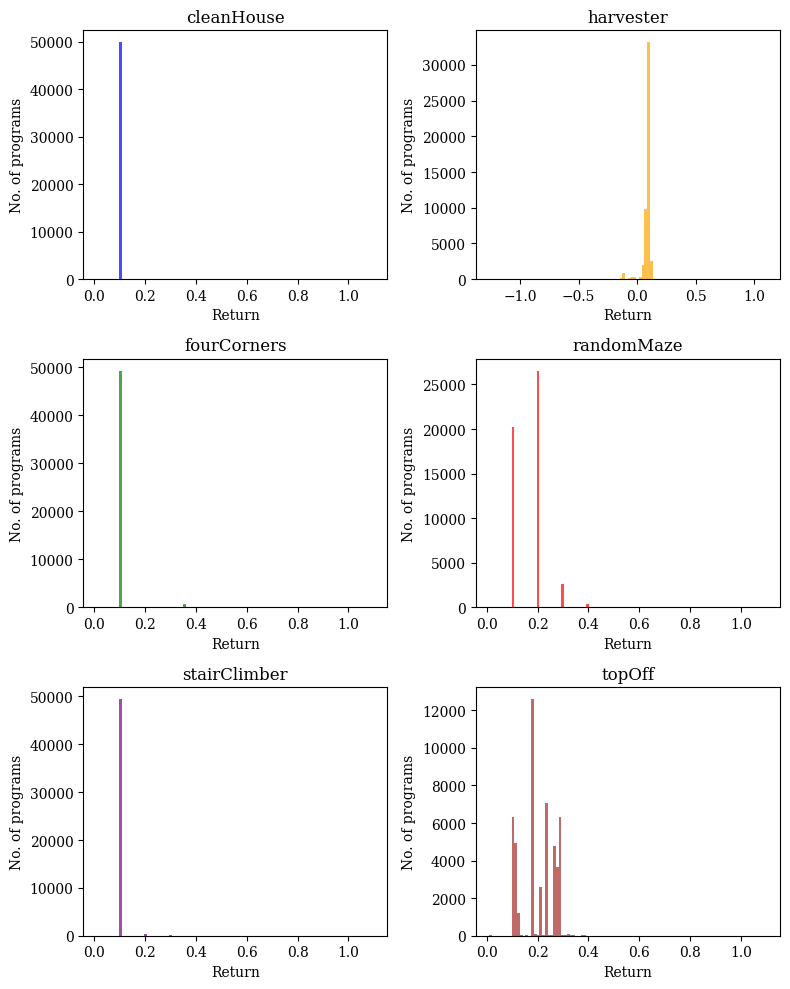

In [9]:
import matplotlib.pyplot as plt

plt.rcParams['font.family'] = 'serif'

num_bins = 100

# Create a figure and arrange subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(8, 10))

# Plot the distributions in each subplot
axes[0, 0].hist(df.cleanHouse_reward, bins=num_bins, range=(df.cleanHouse_reward.min(), 1.1), color='blue', alpha=0.7)
axes[0, 0].set_title('cleanHouse')
axes[0, 0].set_xlabel('Return')
axes[0, 0].set_ylabel('No. of programs')

axes[0, 1].hist(df.harvester_reward, bins=num_bins, range=(df.harvester_reward.min(), 1.1), color='orange', alpha=0.7)
axes[0, 1].set_title('harvester')
axes[0, 1].set_xlabel('Return')
axes[0, 1].set_ylabel('No. of programs')

axes[1, 0].hist(df.fourCorners_reward, bins=num_bins, range=(df.fourCorners_reward.min(), 1.1), color='green', alpha=0.7)
axes[1, 0].set_title('fourCorners')
axes[1, 0].set_xlabel('Return')
axes[1, 0].set_ylabel('No. of programs')

axes[1, 1].hist(df.randomMaze_reward, bins=num_bins, range=(df.randomMaze_reward.min(), 1.1), color='red', alpha=0.7)
axes[1, 1].set_title('randomMaze')
axes[1, 1].set_xlabel('Return')
axes[1, 1].set_ylabel('No. of programs')

axes[2, 0].hist(df.stairClimber_reward, bins=num_bins, range=(df.stairClimber_reward.min(), 1.1), color='purple', alpha=0.7)
axes[2, 0].set_title('stairClimber')
axes[2, 0].set_xlabel('Return')
axes[2, 0].set_ylabel('No. of programs')

axes[2, 1].hist(df.topOff_reward, bins=num_bins, range=(df.topOff_reward.min(), 1.1), color='brown', alpha=0.7)
axes[2, 1].set_title('topOff')
axes[2, 1].set_xlabel('Return')
axes[2, 1].set_ylabel('No. of programs')

# Adjust layout to prevent overlap
plt.tight_layout()

# Save as SVG
plt.savefig('leaps_data.pdf', format='pdf', dpi=300)

# Show the plot
plt.show()

In [ ]:
anomalous = df[df.filter(like='_reward').apply(lambda col: (col < 0) | (col > 1)).any(axis=1)]
print(anomalous)

anomalous.to_csv('anomalous.csv')

In [12]:
tasks = ['cleanHouse', 'harvester', 'fourCorners', 'randomMaze', 'stairClimber', 'topOff']
df[df['harvester_reward'] == df['harvester_reward'].min()].program.values[0]

'DEF run m( putMarker move turnLeft WHILE c( rightIsClear c) w( putMarker move w) m)'

In [14]:
max_len = df[df['prog_len'] == df['prog_len'].max()].program.values[0]
print('\n'.join([f'{idx}, {token}' for idx, token in enumerate(max_len.split())]))

0, DEF
1, run
2, m(
3, IFELSE
4, c(
5, rightIsClear
6, c)
7, i(
8, IF
9, c(
10, not
11, c(
12, markersPresent
13, c)
14, c)
15, i(
16, turnRight
17, i)
18, WHILE
19, c(
20, frontIsClear
21, c)
22, w(
23, turnRight
24, w)
25, i)
26, ELSE
27, e(
28, IF
29, c(
30, markersPresent
31, c)
32, i(
33, IFELSE
34, c(
35, not
36, c(
37, frontIsClear
38, c)
39, c)
40, i(
41, move
42, i)
43, ELSE
44, e(
45, putMarker
46, e)
47, i)
48, e)
49, m)


In [15]:
from collections import Counter
print(Counter(df['fourCorners_reward']))

Counter({0.1000000014901161: 49444, 0.3499999940395355: 538, 0.0099999997764825: 17, 1.100000023841858: 1})
